In [98]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display

In [99]:
PATH_TRAIN_DATA = "musicnet/train_data/"
PATH_TRAIN_LABELS = "musicnet/train_labels/"
PATH_TEST_DATA = "musicnet/test_data/"
PATH_TEST_LABELS = "musicnet/test_labels/"
PATH_METADATA = "musicnet_metadata.csv"

In [100]:
# Load metadata from csv file and filter out non-piano music files
metadata = pd.read_csv(PATH_METADATA)
metadata.drop(metadata[metadata["ensemble"] != "Solo Piano"].index, inplace = True)

ids = metadata["id"].to_numpy()
test_ids = [1759, 2303, 2556]
train_ids = [x for x in ids if x not in test_ids]

In [101]:
ORIGINAL_SR = 44100
TARGET_SR = 16000
FMIN = librosa.note_to_hz("A0")
FMIN_MIDI_INDEX = 21
N_NOTES = 88
BINS_PER_NOTE = 1
BINS_PER_OCTAVE = 12 * BINS_PER_NOTE
N_BINS = N_NOTES * BINS_PER_NOTE

WINDOW_LENGTH = 2048
HOP_LENGTH = 512

frac_sr = TARGET_SR / ORIGINAL_SR
sample_indexer = frac_sr / HOP_LENGTH

In [102]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.preprocessing import StandardScaler

In [111]:
model = Sequential()
model.add(Dense(256, activation=tf.nn.relu, input_shape=(N_BINS,)))
model.add(Dense(N_NOTES, activation=tf.nn.sigmoid))

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               22784     
                                                                 
 dense_9 (Dense)             (None, 88)                22616     
                                                                 
Total params: 45,400
Trainable params: 45,400
Non-trainable params: 0
_________________________________________________________________


In [104]:
"""
x_train = np.load(PATH_TRAIN_DATA+"1733"+ ".npy" ).transpose()
y_train = np.load(PATH_TRAIN_LABELS+"1733"+ ".npy" )

x_test = np.load(PATH_TEST_DATA+"1759"+ ".npy" ).transpose()
y_test = np.load(PATH_TEST_LABELS+"1759"+ ".npy" )
"""

'\nx_train = np.load(PATH_TRAIN_DATA+"1733"+ ".npy" ).transpose()\ny_train = np.load(PATH_TRAIN_LABELS+"1733"+ ".npy" )\n\nx_test = np.load(PATH_TEST_DATA+"1759"+ ".npy" ).transpose()\ny_test = np.load(PATH_TEST_LABELS+"1759"+ ".npy" )\n'

In [108]:
x_train = np.concatenate([np.load(PATH_TRAIN_DATA+str(fname)+".npy").transpose() for fname in train_ids])
y_train = np.concatenate([np.load(PATH_TRAIN_LABELS+str(fname)+".npy") for fname in train_ids])
x_test = np.concatenate([np.load(PATH_TEST_DATA+str(fname)+".npy").transpose() for fname in test_ids])
y_test = np.concatenate([np.load(PATH_TEST_LABELS+str(fname)+".npy") for fname in test_ids])

In [112]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=100)

Epoch 1/5
17087/17087 [==============================] - 30s 2ms/step - loss: 0.0764 - accuracy: 0.3027 - val_loss: 0.0654 - val_accuracy: 0.3132
Epoch 2/5
17087/17087 [==============================] - 27s 2ms/step - loss: 0.0721 - accuracy: 0.3141 - val_loss: 0.0649 - val_accuracy: 0.2982
Epoch 3/5
17087/17087 [==============================] - 28s 2ms/step - loss: 0.0715 - accuracy: 0.3150 - val_loss: 0.0647 - val_accuracy: 0.3106
Epoch 4/5
17087/17087 [==============================] - 28s 2ms/step - loss: 0.0712 - accuracy: 0.3156 - val_loss: 0.0646 - val_accuracy: 0.3031
Epoch 5/5
17087/17087 [==============================] - 30s 2ms/step - loss: 0.0710 - accuracy: 0.3161 - val_loss: 0.0639 - val_accuracy: 0.3121


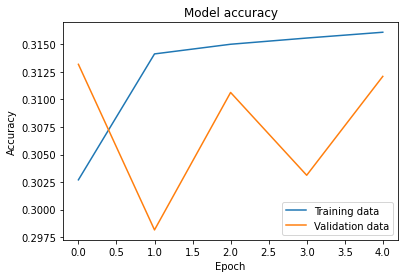

In [113]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim(0, 1)
plt.legend(['Training data', 'Validation data'], loc='lower right')
plt.show()

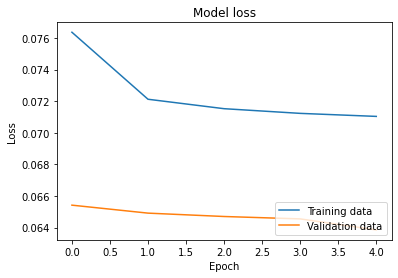

In [114]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.legend(['Training data', 'Validation data'], loc='lower right')
plt.show()

In [117]:
score = model.evaluate(x_test, y_test)

429/429 [==============================] - 1s 1ms/step - loss: 0.0639 - accuracy: 0.3121


(88, 2896)
(88, 2896)


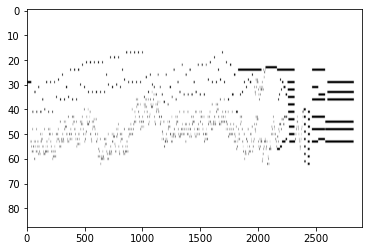

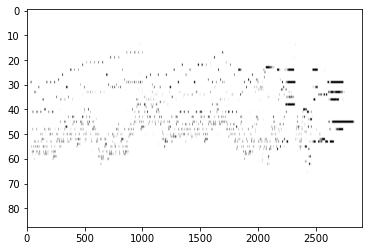

In [120]:
x = np.load(PATH_TEST_DATA+"2303"+ ".npy" ).transpose()
y = np.load(PATH_TEST_LABELS+"2303"+ ".npy" )

prediction = model.predict(x).round().transpose()
truth = y.transpose()

print(prediction.shape)
print(truth.shape)

end_seconds = 100
end_index = round(end_seconds/(0.032))

plt.figure()
plt.subplot()
plt.imshow(truth[:,0:end_index],cmap='Greys',aspect='auto')

plt.figure()
plt.subplot()
plt.imshow(prediction[:,0:end_index],cmap='Greys',aspect='auto')